In [1]:
import os
import time as timer

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import numpy as np

from sklearn.preprocessing import MinMaxScaler

from torchvision import datasets
import torchvision.transforms as T

## My own modules
import viz_utils as vu
import train_utils as tu
import model_utils as mu
###

import imp
imp.reload(vu)
imp.reload(mu)
imp.reload(tu)

/var/folders/wb/ttr9x7pn27q1_rp5vtjfr0s00000gn/T/ipykernel_3417/3262691840.py:22: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


<module 'train_utils' from '/Users/mghifary/Work/govtech/codes/AI/unslearning/train_utils.py'>

In [2]:
DATA_DIR = "../data"
MODEL_DIR = "../models"

EPOCHS = 100
dh = 512
dz = 20
# dh = 1000
# dz = 200

# model_path = os.path.join(MODEL_DIR, "vae_ep%d_h%d_z%d_mnist.pth" % (EPOCHS, dh, dz))
model_path = os.path.join(MODEL_DIR, "vae_ep%d_h%d_z%d_beta075_mnist.pth" % (EPOCHS, dh, dz))
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Load dataset
training_data = datasets.MNIST(
    root=DATA_DIR, 
    train=True, 
    download=True,
    transform=T.ToTensor(), #convert to Tensor and normalize to (0, 1)
)

test_data = datasets.MNIST(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=T.ToTensor(), #convert to Tensor and normalize to (0, 1)
)

[n, dx1, dx2] = training_data.data.shape

In [4]:
print(f"Using {DEVICE} device")

# Define model
model = mu.VAE(d_in=dx1*dx2, d_z=dz, d_h=dh).to(DEVICE)

model.load_state_dict(torch.load(model_path))
model.eval()

print(model)

Using cpu device
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [5]:
X2d = training_data.data
X2d_t = test_data.data

In [6]:
X = torch.reshape(X2d, (-1, dx1 * dx2))
Xt = torch.reshape(X2d_t, (-1, dx1 * dx2))

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
Xn = torch.from_numpy(scaler.fit_transform(X))
Xn_t = torch.from_numpy(scaler.transform(Xt))

In [8]:
Xn = Xn.float()
Xn_t = Xn_t.float()

In [9]:
# Reconstruct
Xrec, _, _ = model(Xn)
Xrec_t, _, _ = model(Xn_t)

img_np : 0.0 1.0


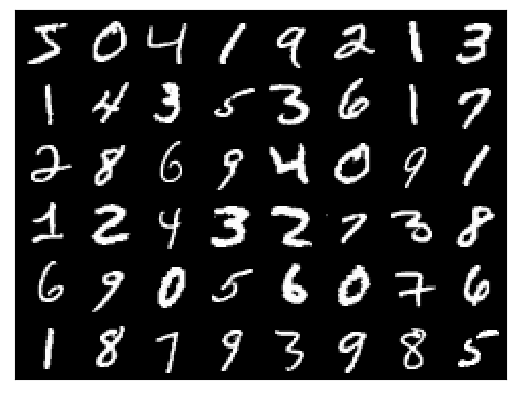

In [10]:
# Training data
grid = vu.set_grid(X2d, num_cells=48)
vu.show(grid)

img_np : 0.0 1.0


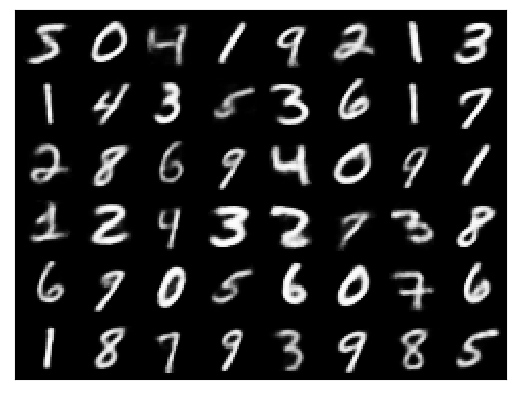

In [11]:
# Training reconstruction
V = torch.reshape(Xrec, (-1, dx1, dx2))
grid = vu.set_grid(V, num_cells=48)
vu.show(grid)

img_np : 0.0 1.0


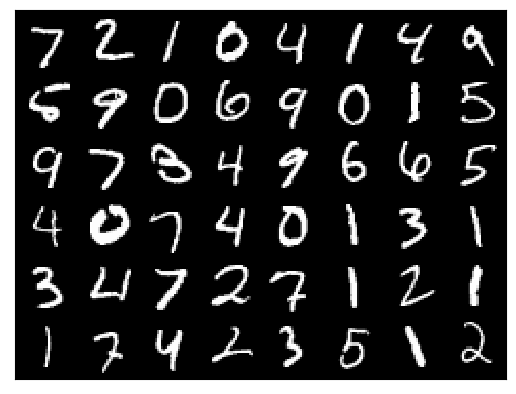

In [12]:
# Test data
grid = vu.set_grid(X2d_t, num_cells=48)
vu.show(grid)

img_np : 0.0 1.0


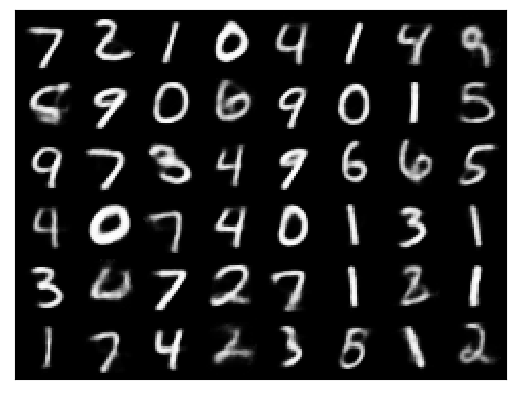

In [13]:
# Test reconstruction
V = torch.reshape(Xrec_t, (-1, dx1, dx2))
grid = vu.set_grid(V, num_cells=48)
vu.show(grid)

In [14]:
train_rec_loss = torch.mean(torch.sqrt(torch.sum((Xn - Xrec)**2, 1)))
test_rec_loss = torch.mean(torch.sqrt(torch.sum((Xn_t - Xrec_t)**2, 1)))

print(f"Train reconstruction loss: {train_rec_loss:>.2f}")
print(f"Test reconstruction loss: {test_rec_loss:>.2f}")

Train reconstruction loss: 2.97
Test reconstruction loss: 2.98


In [15]:
# Check latent codes
Z, mu, logvar = model.encode(Xn)
Zt, mu_t, logvar_t = model.encode(Xn_t)

In [16]:
Zt.min(), Zt.max(), Zt.mean()

(tensor(-3.4311, grad_fn=<MinBackward1>),
 tensor(3.5357, grad_fn=<MaxBackward1>),
 tensor(0.0449, grad_fn=<MeanBackward0>))

In [17]:
Xdec_t = model.decode(Zt)

## Create Slider UI to Manipulate the Latent Codes

In [18]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

In [19]:
def decode_and_display(model, zc):
    xc = model.decoder(zc)
    grid = vu.set_grid(torch.reshape(xc, (1, dx1, dx2)), num_cells=1)
    vu.show(grid)
    
def show_image(t):
    zc = Zt[t]
    decode_and_display(model, zc)

In [20]:
interact(show_image, t=widgets.IntSlider(min=0, max=1000, step=1, value=0));

interactive(children=(IntSlider(value=0, description='t', max=1000), Output()), _dom_classes=('widget-interact…

In [21]:
Zc = torch.clone(Zt)

In [22]:
zc = Zc[500]
# zc = torch.zeros(dz)

zw_list = []
for i in range(20):
    zw_list.append(widgets.FloatSlider(min=-15, max=15, step=0.1, value=zc[i]))

l2 = int(len(zw_list) / 2)

ui1 = widgets.VBox(zw_list[:l2])
ui2 = widgets.VBox(zw_list[l2:])
ui = widgets.HBox([ui1, ui2])

In [23]:
def f(**kwargs):
    zc = torch.zeros(dz)
    for key, val in kwargs.items():
        ikey = int(key)
        zc[ikey] = val
        
    decode_and_display(model, zc)

zcodes = {}
for i in range(len(zw_list)):
    key = str(i)
    zcodes[key] = zw_list[i]
out = widgets.interactive_output(f, zcodes)

display(ui, out)

Output()

#### Image Morphing

In [24]:
def morph(model, xs, xt, n_steps=5):
    """
    Args:
        model (nn.Module): VAE model
        xs (torch.Tensor): source image vector
        xt (torch.Tensor): target image vector
        n_steps (int): number 
    
    """
    # Visualize inputs
    X_input = torch.stack([xs, xt], dim=0)
    X2d = X_input.reshape((-1, dx1, dx2))
    grid = vu.set_grid(X2d, num_cells=2)
    vu.show(grid)
    
    zs, _, _ = model.encode(xs)
    zt, _, _ = model.encode(xt)
    
    # Linear interpolate on Z codes
    t_list = np.linspace(0, 1, n_steps).tolist()
    z_list = []
    for t in t_list:
        z_list.append(torch.lerp(zs, zt, t))

    Zm = torch.stack(z_list, dim=0)
    [n, d1, d2] = Zm.shape
    Zm = Zm.reshape((n, d2))

    # Decode morphed images
    Xm = model.decode(Zm)
    
    # Visualize the morphed images
    X2d = Xm.reshape((-1, dx1, dx2))
    grid = vu.set_grid(X2d, num_cells=len(z_list))
    vu.show(grid)
    

img_np : 0.0 1.0
img_np : 0.0 1.0


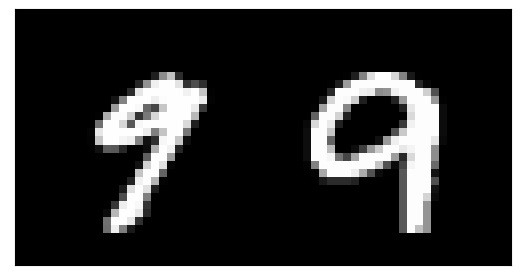

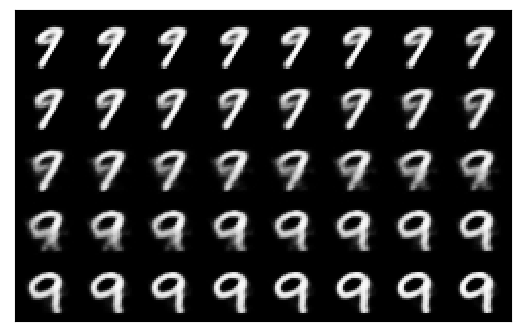

In [27]:
morph(model, Xn_t[20], Xn_t[501], n_steps=40)